In [1]:
LABELS = [0, 0, 1, 1]
CENTERS = [(-3, -3), (3, 3), (3, -3), (-3, 3)]

In [2]:
!which python

/home/raghavan/anaconda3/bin/python


In [50]:
import numpy as np
from torch import nn , optim
import torch
import plotly
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
%matplotlib inline

In [51]:
def create_toy_data(data_size):
    num_centers = len(CENTERS)
    
    x_data = []
    y_data = []
    
    for i in range(data_size):
        center_idx = np.random.randint(num_centers)
        x_data.append(np.random.normal(loc=CENTERS[center_idx]))
        y_data.append(LABELS[center_idx])
    
    return torch.tensor(x_data,dtype = torch.float32),torch.tensor(y_data,dtype = torch.float32)
        

In [52]:
toy_data = create_toy_data(1000)
toy_df = pd.DataFrame(toy_data[0].numpy()[:,0],columns=["x"])
toy_df["y"] = toy_data[0].numpy()[:,1]
toy_df["class"] = toy_data[1].numpy()

In [53]:
toy_df.head()

,x,y,class
0,1.924330,3.969998,0.0
1,-2.454349,-2.154405,0.0
2,3.627309,-2.477740,1.0
3,2.598312,2.272529,0.0
4,-2.325206,4.383315,1.0


In [59]:
def visualize_results(perceptron, x_data, y_truth, n_samples=1000, ax=None, epoch=None, 
                      title='', levels=[0.3, 0.4, 0.5], linestyles=['--', '-', '--']):
    _, y_pred = perceptron(x_data, apply_softmax=True)
    y_pred = y_pred.data.numpy()

    x_data = x_data.data.numpy()
    y_truth = y_truth.data.numpy()


    n_classes = len(set(LABELS))

    all_x = [[] for _ in range(n_classes)]
    all_colors = [[] for _ in range(n_classes)]
    
    colors = ['black', 'white']
    markers = ['o', '*']
    
    for x_i, y_pred_i, y_true_i in zip(x_data, y_pred, y_truth):
        all_x[y_true_i].append(x_i)
        if y_pred_i == y_true_i:
            all_colors[y_true_i].append("white")
        else:
            all_colors[y_true_i].append("black")
        #all_colors[y_true_i].append(colors[y_pred_i])

    all_x = [np.stack(x_list) for x_list in all_x]

    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(10,10))
        
    for x_list, color_list, marker in zip(all_x, all_colors, markers):
        ax.scatter(x_list[:, 0], x_list[:, 1], edgecolor="black", marker=marker, facecolor=color_list, s=100)
    
        
    xlim = (min([x_list[:,0].min() for x_list in all_x]), 
            max([x_list[:,0].max() for x_list in all_x]))
            
    ylim = (min([x_list[:,1].min() for x_list in all_x]), 
            max([x_list[:,1].max() for x_list in all_x]))
            
    # hyperplane
    
    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    
    for i in range(n_classes):
        Z = perceptron(torch.tensor(xy, dtype=torch.float32), 
                       apply_softmax=True)
        Z  = Z[:, i].data.numpy().reshape(XX.shape)
        ax.contour(XX, YY, Z, colors=colors[i], levels=levels, linestyles=linestyles)
    
    # plotting niceties
    
    plt.suptitle(title)
    
    if epoch is not None:
        plt.text(xlim[0], ylim[1], "Epoch = {}".format(str(epoch)))

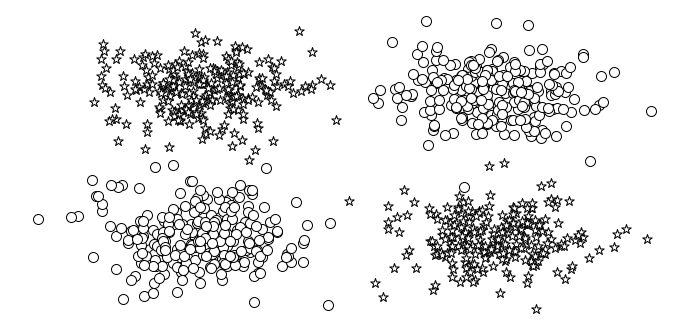

In [60]:

seed = 24

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

x_data, y_truth = create_toy_data(1000)

x_data = x_data.data.numpy()
y_truth = y_truth.data.numpy().astype(np.int64)

n_classes = len(set(LABELS))

all_x = [[] for _ in range(n_classes)]
all_colors = [[] for _ in range(n_classes)]

colors = ['black', 'white']
markers = ['o', '*']

for x_i, y_true_i in zip(x_data, y_truth):
    all_x[y_true_i].append(x_i)
    all_colors[y_true_i].append(colors[y_true_i])

all_x = [np.stack(x_list) for x_list in all_x]


_, ax = plt.subplots(1, 1, figsize=(10,5))

for x_list, color_list, marker in zip(all_x, all_colors, markers):
    ax.scatter(x_list[:, 0], x_list[:, 1], edgecolor='black', marker=marker, facecolor="white", s=100)

plt.tight_layout()
plt.axis('off')

plt.title("");

In [61]:
class MLP(nn.Module):
    def __init__(self,input_dim,hidden_size,output_classes,hiddenlayers,hidden_activation=nn.Sigmoid):
        
        super(MLP, self).__init__()

        input_d = input_dim
        output_d = hidden_size
        
        self.modules = []
        for i in range(hiddenlayers + 1):
            self.modules.append(nn.Linear(input_dim,output_d))
            self.modules.append(hidden_activation())
            input_d = output_d
        
        self.fc_final = nn.Linear(input_d,output_classes)
               
    def forward(self,x_in,apply_softmax=False):
        x_in.to("cpu").numpy()
        for i in self.modules:
            x_in = i(x_in)
            
        output = self.fc_final(x_in,)
        if apply_softmax:
            output = F.softmax(output, dim=1)
    

In [62]:
x_data, y_truth = create_toy_data(1000)

x_data = x_data.data.numpy()
y_truth = y_truth.data.numpy().astype(np.int64)

n_classes = len(set(LABELS))


In [64]:
input_size = 2
output_size = len(set(LABELS))
num_hidden_layers = 1
hidden_size = 2

seed = 2

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

mlp2 = MLP(input_dim=input_size,hidden_size=hidden_size,hiddenlayers=num_hidden_layers,output_classes=output_size)
print(mlp2)
x_data_static, y_truth_static = create_toy_data(1000)



MLP(
  (fc_final): Linear(in_features=2, out_features=2, bias=True)
)
